In [1]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import praw
import pandas as pd 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from datetime import datetime, timedelta

In [4]:
#Initialize Vader sentiment analyzer 
sid = SentimentIntensityAnalyzer()

In [5]:
# reddit API

reddit = praw.Reddit(client_id = 'HKflocOpruhbtDpNMpt_FA', 
                    client_secret = 'zTiq5V4tETOGtp1rzAYyNh7kNdmMnw', 
                    user_agent = 'Jaydip732')


In [6]:
# Subreddit and time period
subreddit = reddit.subreddit('wallstreetbets')
start_date = datetime.now() - timedelta(days = 30)
end_date = datetime.now()


In [7]:
# collect reddit posts
def get_reddit_posts(subreddit, start_date, end_date):
    posts= []
    for submission in subreddit.new(limit=1000):
        post_time = datetime.utcfromtimestamp(submission.created_utc)
        if start_date<=post_time<=end_date:
            sentiment_score =  sid.polarity_scores(submission.title+" "+ submission.selftext)['compound']
            posts.append({
                'title': submission.title,
                'body': submission.selftext,
                'sentiment': sentiment_score, 
                'timestamp': post_time, 
                'score': submission.score, 
                'upvotes': submission.ups,
                'downvotes': submission.downs
            })
    return pd.DataFrame(posts)

#Fetch Reddit Posts
reddit_data = get_reddit_posts(subreddit, start_date, end_date)
reddit_data['date'] = reddit_data['timestamp'].dt.date

print(reddit_data.head())
    

C:\Users\Jaydip\AppData\Local\Temp\ipykernel_2464\3714170341.py:5: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  post_time = datetime.utcfromtimestamp(submission.created_utc)


                                     title  \
0          I found our most regarded king    
1  Power Metals: A Cesium Monopoly ( PMW )   
2                             China stocks   
3        Google to get into Nuclear Power    
4           China Stimulus Unhappy Ending    

                                                body  sentiment  \
0                                                        0.0000   
1  Power Metals: A Cesium Monopoly\n\nPower Metal...     0.9259   
2  Since today china stock market is back in busi...     0.8020   
3  Google Talks to Utilities About Nuclear Power ...     0.9300   
4                                                       -0.4215   

            timestamp  score  upvotes  downvotes        date  
0 2024-10-08 06:36:27      1        1          0  2024-10-08  
1 2024-10-08 06:29:09      3        3          0  2024-10-08  
2 2024-10-08 06:16:45      0        0          0  2024-10-08  
3 2024-10-08 06:08:05      1        1          0  2024-10-08  
4 202

In [8]:
reddit_data.to_csv('sentiment.csv', index=False)

In [9]:
import yfinance as yf

In [10]:
#Define the function to get stock data 
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [11]:
#Fetch Stock
stock_data = get_stock_data('MSFT', start_date, end_date)

#Add a date Column to stock data 
stock_data['date'] = stock_data.index.date


[*********************100%***********************]  1 of 1 completed


In [12]:
print(stock_data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-09  407.239990  408.649994  402.149994  405.720001  405.720001   
2024-09-10  408.200012  416.329987  407.700012  414.200012  414.200012   
2024-09-11  415.500000  423.989990  409.579987  423.040009  423.040009   
2024-09-12  423.309998  427.369995  419.750000  427.000000  427.000000   
2024-09-13  425.829987  431.829987  425.459991  430.589996  430.589996   

              Volume        date  
Date                              
2024-09-09  15295100  2024-09-09  
2024-09-10  19594300  2024-09-10  
2024-09-11  19266900  2024-09-11  
2024-09-12  17418800  2024-09-12  
2024-09-13  15874600  2024-09-13  


In [13]:
#Data Processing for Visualizationabs

#Aggeregate the Reddit sentiment scores by datetime
daily_sentiment = reddit_data.groupby('date')['sentiment'].mean().reset_index() 

#calculate daily stock price change in percentage 
stock_data['daily_return'] = stock_data['Close'].pct_change() * 100
daily_stock = stock_data[['date', 'daily_return']].dropna().reset_index(drop=True)

#Merge Reddit sentiment with stock price data on ddatetime

merged_data = pd.merge(daily_sentiment, daily_stock, on='date', how='inner')

In [14]:
print(merged_data)

          date  sentiment  daily_return
0   2024-09-19   0.258368      1.829114
1   2024-09-20   0.174284     -0.779597
2   2024-09-23   0.134439     -0.404342
3   2024-09-24   0.225143     -1.001129
4   2024-09-25   0.167628      0.685037
5   2024-09-26   0.232730     -0.185135
6   2024-09-27   0.198630     -0.762794
7   2024-09-30   0.056419      0.532685
8   2024-10-01   0.199165     -2.233322
9   2024-10-02   0.041195     -0.846228
10  2024-10-03   0.113859     -0.141442
11  2024-10-04   0.187266     -0.115238
12  2024-10-07   0.327307     -1.567079


In [15]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [16]:
sns.set(style='whitegrid')

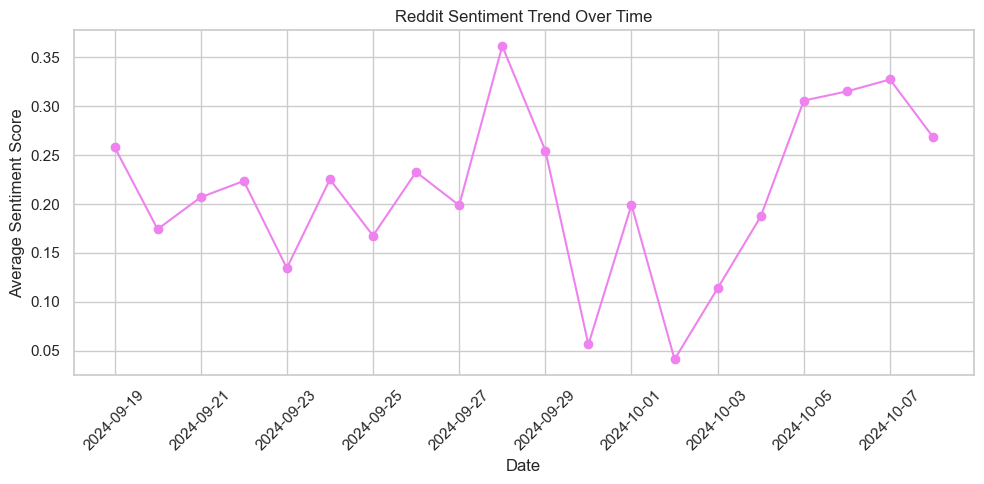

In [19]:
#plot Sentiment trend over time 
plt.figure(figsize=(10, 5))
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment'], color = 'violet', marker= 'o' )
plt.title('Reddit Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

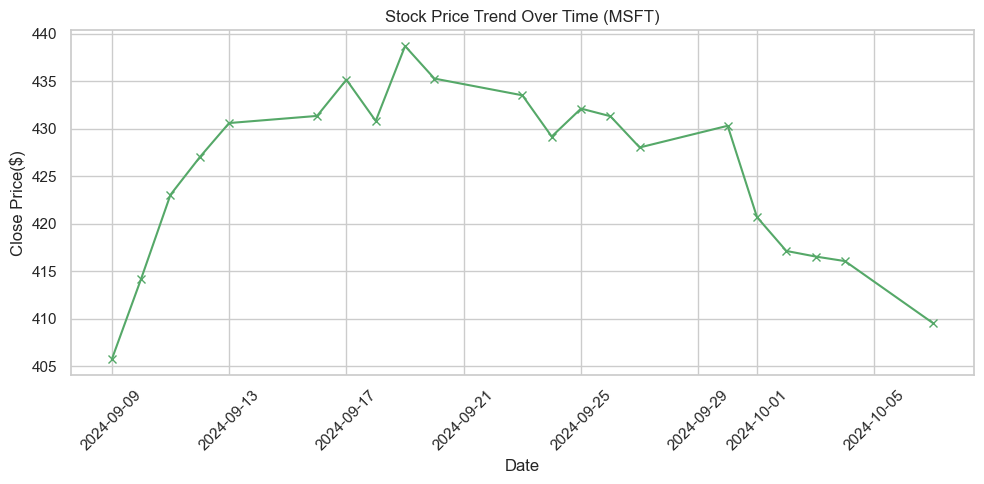

In [52]:
#Plotting Stock Price Movement over time 
plt.figure(figsize=(10, 5))
plt.plot(stock_data['date'], stock_data['Close'], color = 'g', marker = 'x')
plt.title('Stock Price Trend Over Time (MSFT)')
plt.xlabel('Date')
plt.ylabel('Close Price($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

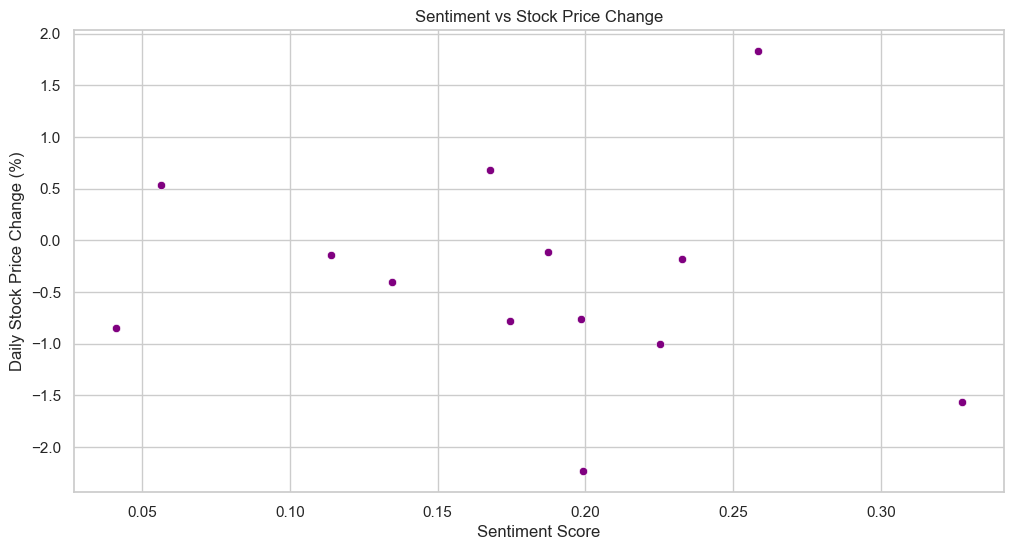

In [20]:
# Scatter plot: Sentiment vs Stock Price movement
plt.figure(figsize=(12, 6))
sns.scatterplot(x='sentiment', y='daily_return', data=merged_data, color='purple')
plt.title('Sentiment vs Stock Price Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Stock Price Change (%)')
plt.grid(True)
plt.show()


In [21]:
#compute 7 day rolling average for both sentiment and stock returns 
merged_data['sentiment_rolling_avg'] = merged_data['sentiment'].rolling(window=7).mean() 
merged_data['stock_return_rolling_avg'] = merged_data['daily_return'].rolling(window=7).mean()



<function matplotlib.pyplot.show(close=None, block=None)>

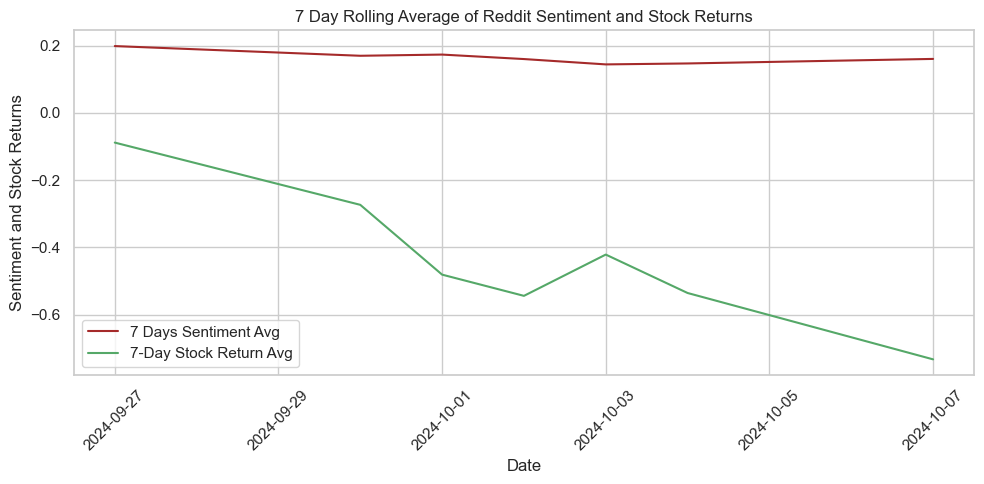

In [22]:
#Plot 7 day rolling average of sentiment and stock return

plt.figure(figsize=(10, 5))
plt.plot(merged_data['date'], merged_data['sentiment_rolling_avg'], label = '7 Days Sentiment Avg', color= 'brown')
plt.plot(merged_data['date'], merged_data['stock_return_rolling_avg'], label='7-Day Stock Return Avg', color='g')
plt.title('7 Day Rolling Average of Reddit Sentiment and Stock Returns')
plt.xlabel('Date')
plt.ylabel('Sentiment and Stock Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

In [23]:
# Calculate Pearson correlation between sentiment and stock price returns
correlation = merged_data['sentiment'].corr(merged_data['daily_return'])

# Print the correlation coefficient
print(f"Correlation between Reddit sentiment and stock price movement: {correlation:.2f}")


Correlation between Reddit sentiment and stock price movement: -0.14
